In [1]:
# Core
import math
import copy
import pandas as pd
from datetime import datetime

# ---- Your turbine model (provided) ----
# Uses a bi-directional storage/turbine unit with ramp & SoE constraints.
# Defaults (you can override via HydroStorageConfig):
#   max_discharge_mw=12, min_discharge_mw=7, ramp_mw_per_min=6,
#   capacity_mwh=45, initial_soe_mwh=45, eta_charge=1, eta_discharge=1
# (Min enforcement on non-zero targets; ramp can pass through below-min values.)
from src.models.FEB_turbine_unit_U4 import HydroStorageConfig, HydroStorageUnit, make_unit  # noqa
# ^ If your other two units live in separate files, e.g. FEB_turbine_unit_U2.py,
#   import them similarly and create them with their own make_unit/config.

# ---- Your FiT revenue function (provided) ----
from revenue_function import (
    detect_time_window_for_aligned_blocks,
    compute_revenue_rows,
)

import pulp as pl

C:\Users\Jarup\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Jarup\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


In [2]:
# EXAMPLE skeleton (do NOT run as-is). Replace with your real data loading.
csv_path = "data/day_ahead_15min_MW.csv" 
schedule_df = pd.read_csv(csv_path, parse_dates=["timestamp"])
schedule_df["ts_start"] = pd.to_datetime(schedule_df["timestamp"])
schedule_df["contract_kwh"] = 45*1000
schedule_df["egat_plan_kwh"] = 45*0.6*1000
schedule_df["has_egat_plan_in_win3"] = 0.6*45*1000
schedule_df['fit_rate'] = 4
schedule_df['solar_kwh'] = schedule_df["solar_forecast_mw"] * 1000
# For safety, assert required columns exist:
required_cols = [
    "ts_start", "fit_rate", "contract_kwh", "egat_plan_kwh",
    "has_egat_plan_in_win3", "solar_kwh"
]
missing = [c for c in required_cols if c not in schedule_df.columns]
assert not missing, f"Missing required columns: {missing}"
schedule_df = schedule_df.sort_values("ts_start").reset_index(drop=True)

In [3]:
schedule_df

,timestamp,solar_forecast_mw,ts_start,contract_kwh,egat_plan_kwh,has_egat_plan_in_win3,fit_rate,solar_kwh
0,2026-01-03 00:00:00,0.0,2026-01-03 00:00:00,45000,27000.0,27000.0,4,0.0
1,2026-01-03 00:15:00,0.0,2026-01-03 00:15:00,45000,27000.0,27000.0,4,0.0
2,2026-01-03 00:30:00,0.0,2026-01-03 00:30:00,45000,27000.0,27000.0,4,0.0
3,2026-01-03 00:45:00,0.0,2026-01-03 00:45:00,45000,27000.0,27000.0,4,0.0
4,2026-01-03 01:00:00,0.0,2026-01-03 01:00:00,45000,27000.0,27000.0,4,0.0
...,...,...,...,...,...,...,...,...
91,2026-01-03 22:45:00,0.0,2026-01-03 22:45:00,45000,27000.0,27000.0,4,0.0
92,2026-01-03 23:00:00,0.0,2026-01-03 23:00:00,45000,27000.0,27000.0,4,0.0
93,2026-01-03 23:15:00,0.0,2026-01-03 23:15:00,45000,27000.0,27000.0,4,0.0
94,2026-01-03 23:30:00,0.0,2026-01-03 23:30:00,45000,27000.0,27000.0,4,0.0


In [4]:
ADJUST_FACTOR = 14.0/15.0  # must align with revenue_function
BLOCK_MINUTES = 15
BLOCK_HOURS = BLOCK_MINUTES / 60.0

def base_and_adjust_for_row(ts, contract_kwh, egat_plan_kwh, has_egat_plan_in_win3):
    window_id, adjusted = detect_time_window_for_aligned_blocks(ts)
    if window_id == 1:
        base_kwh = float(contract_kwh)
    elif window_id == 2:
        base_kwh = float(egat_plan_kwh)
    else:  # window 3
        if bool(has_egat_plan_in_win3):
            base_kwh = float(egat_plan_kwh)
        else:
            base_kwh = float(contract_kwh)
    return base_kwh, adjusted

# Compute base, adjusted flag, and the **economic meter target** for each row
tmp = schedule_df.apply(
    lambda r: base_and_adjust_for_row(
        r["ts_start"], r["contract_kwh"], r["egat_plan_kwh"], r["has_egat_plan_in_win3"]
    ), axis=1
)
schedule_df[["base_kwh", "adjusted_flag"]] = pd.DataFrame(tmp.tolist(), index=schedule_df.index)
schedule_df["target_meter_kwh"] = schedule_df["base_kwh"] / schedule_df["adjusted_flag"].map(
    lambda adj: ADJUST_FACTOR if adj else 1.0
)

In [5]:
# Option A: all three units are the same type as U4 (replace/adjust as needed)
u1 = make_unit(HydroStorageConfig())  # name='U1' inside factory
u2 = make_unit(HydroStorageConfig())
u3 = make_unit(HydroStorageConfig())

# If you actually have different modules, e.g. FEB_turbine_unit_U2/U3:
# from FEB_turbine_unit_U2 import make_unit as make_unit_U2, HydroStorageConfig as CfgU2
# from FEB_turbine_unit_U3 import make_unit as make_unit_U3, HydroStorageConfig as CfgU3
# u1 = make_unit(HydroStorageConfig(...))
# u2 = make_unit_U2(CfgU2(...))
# u3 = make_unit_U3(CfgU3(...))

units = [u1, u2, u3]

In [6]:
def feasible_discharge_mw(unit: HydroStorageUnit, dt_min: float) -> float:
    """One-step dry-run to estimate how much this unit could actually deliver (MW) this sub-step."""
    sim = copy.deepcopy(unit)
    sim.request_power(sim.config.max_discharge_mw)  # ask for max, policy & ramp/SoE will clip
    p = sim.step(dt_min)
    return max(0.0, p)

def dispatch_one_block_to_target(units, target_kwh_from_turbines: float, substeps: int = 3):
    """
    Dispatch turbines over a 15-min block to meet 'target_kwh_from_turbines' as closely as possible.
    Returns: (delivered_kwh_total, [avg_MW_per_block per unit], [kWh_per_block per unit])
    """
    dt_min_total = BLOCK_MINUTES
    dt_min = dt_min_total / substeps
    delivered_kwh = [0.0 for _ in units]
    delivered_mw_sum = [0.0 for _ in units]  # accumulate to compute per-block average MW
    remaining_kwh = max(0.0, target_kwh_from_turbines)

    for _ in range(substeps):
        # Convert remaining energy (kWh) to average MW over this sub-step
        required_mw = remaining_kwh / (dt_min / 60.0)

        # Estimate feasible discharge this sub-step per unit
        feas = [feasible_discharge_mw(u, dt_min) for u in units]
        sum_feas = sum(feas)

        # Determine requests
        if sum_feas <= 1e-6:
            # Nothing left in turbines this sub-step
            for u in units:
                u.request_power(0.0)
        else:
            if required_mw >= sum_feas:
                # Even full-out we can't meet the need: request full feasible
                for i, u in enumerate(units):
                    # Requesting max_discharge enables ramp/SoE to clip to 'feas[i]'
                    u.request_power(u.config.max_discharge_mw)
            else:
                # Scale each unit proportionally to its feasible power
                scale = required_mw / sum_feas
                for i, u in enumerate(units):
                    # Aim slightly above to counteract min-enforcement/ramp rounding, but keep within nameplate
                    want = min(u.config.max_discharge_mw, feas[i] * max(0.0, scale))
                    u.request_power(want)

        # Execute this real sub-step and accumulate results
        for i, u in enumerate(units):
            p = u.step(dt_min)  # MW actually achieved this sub-step
            delivered_mw_sum[i] += p
            delivered_kwh[i] += p * (dt_min / 60.0)

        # Update remaining
        produced_kwh = sum(p * (dt_min / 60.0) for p in delivered_mw_sum)  # total so far this block
        # But we only subtract what we produced in this sub-step:
        produced_kwh_sub = sum(delivered_kwh) - (target_kwh_from_turbines - remaining_kwh)
        remaining_kwh = max(0.0, remaining_kwh - produced_kwh_sub)

    # Average MW over the full 15-min block
    avg_mw_per_block = [mw_sum / substeps for mw_sum in delivered_mw_sum]
    return sum(delivered_kwh), avg_mw_per_block, delivered_kwh

In [7]:
results = []
for idx, row in schedule_df.iterrows():
    # Meter target for this block (kWh)
    meter_target_kwh = float(row["target_meter_kwh"])
    solar_kwh = max(0.0, float(row["solar_kwh"]))

    # Turbine energy target = what's needed beyond solar (no benefit to exceed meter target)
    need_from_turbines_kwh = max(0.0, meter_target_kwh - solar_kwh)

    # Dispatch turbines
    delivered_kwh_turbines, avg_mw_per_block, kwh_per_block = dispatch_one_block_to_target(
        units, need_from_turbines_kwh, substeps=3
    )

    # Meter energy actually produced (PV + turbines). We do NOT curtail PV here;
    # if PV > target, revenue function will cap payable and you get no penalty.
    meter_e_read_kwh = solar_kwh + delivered_kwh_turbines

    results.append({
        "ts_start": row["ts_start"],
        "fit_rate": row["fit_rate"],
        "contract_kwh": row["contract_kwh"],
        "egat_plan_kwh": row["egat_plan_kwh"],
        "has_egat_plan_in_win3": row["has_egat_plan_in_win3"],
        "solar_kwh": solar_kwh,
        "turb1_mw": avg_mw_per_block[0],
        "turb2_mw": avg_mw_per_block[1],
        "turb3_mw": avg_mw_per_block[2],
        "turb1_kwh": kwh_per_block[0],
        "turb2_kwh": kwh_per_block[1],
        "turb3_kwh": kwh_per_block[2],
        "turbines_kwh": delivered_kwh_turbines,
        "meter_e_read_kwh": meter_e_read_kwh,     # <-- This is 'e_read_kwh' for revenue calc
        "target_meter_kwh": meter_target_kwh,      # For diagnostics
        "base_kwh": row["base_kwh"],               # For diagnostics
        "adjusted_flag": row["adjusted_flag"],     # For diagnostics
    })

dispatch_df = pd.DataFrame(results)

In [8]:
# revenue_input_cols = [
#     "ts_start", "fit_rate", "meter_e_read_kwh",
#     "contract_kwh", "egat_plan_kwh", "has_egat_plan_in_win3"
# ]
revenue_input_cols = [
    "ts_start", "fit_rate", "e_read_kwh",
    "contract_kwh", "egat_plan_kwh", "has_egat_plan_in_win3"
]
rf_df = dispatch_df.rename(columns={"meter_e_read_kwh": "e_read_kwh"}).loc[:, revenue_input_cols]
rev_df = compute_revenue_rows(rf_df)

# Merge back for a complete view
full_df = dispatch_df.merge(rev_df, on=["ts_start", "fit_rate", "contract_kwh",
                                        "egat_plan_kwh", "has_egat_plan_in_win3"],
                            how="left")

total_payment = full_df["payment_currency"].sum()
total_penalty = full_df["penalty_currency"].sum()

print(f"Total revenue (currency): {total_payment:,.2f}")
print(f"Total penalties (currency): {total_penalty:,.2f}")

Total revenue (currency): 6,090,486.11
Total penalties (currency): 682,019.35


In [9]:
full_df["shortfall_vs_base_kwh"] = full_df["base_kwh_y"] - full_df["e_use_kwh"]
full_df["shortfall_vs_base_kwh"] = full_df["shortfall_vs_base_kwh"].clip(lower=0)

cols_show = [
    "ts_start", "solar_kwh",
    "turb1_mw", "turb2_mw", "turb3_mw",
    "turbines_kwh", "meter_e_read_kwh",
    "base_kwh_y", "adjusted_flag",
    "e_use_kwh", "payable_kwh",
    "shortfall_vs_base_kwh",
    "penalty_currency", "payment_currency"
]
display(full_df[cols_show].head(24))

,ts_start,solar_kwh,turb1_mw,turb2_mw,turb3_mw,turbines_kwh,meter_e_read_kwh,base_kwh_y,adjusted_flag,e_use_kwh,payable_kwh,shortfall_vs_base_kwh,penalty_currency,payment_currency
0,2026-01-03 00:00:00,0.0,12.0,12.0,12.0,9.0,9.0,27000.0,False,9.0,9.0,26991.0,12955.68,-12919.68
1,2026-01-03 00:15:00,0.0,12.0,12.0,12.0,9.0,9.0,27000.0,False,9.0,9.0,26991.0,12955.68,-12919.68
2,2026-01-03 00:30:00,0.0,12.0,12.0,12.0,9.0,9.0,27000.0,False,9.0,9.0,26991.0,12955.68,-12919.68
3,2026-01-03 00:45:00,0.0,12.0,12.0,12.0,9.0,9.0,27000.0,False,9.0,9.0,26991.0,12955.68,-12919.68
4,2026-01-03 01:00:00,0.0,12.0,12.0,12.0,9.0,9.0,27000.0,False,9.0,9.0,26991.0,12955.68,-12919.68
5,2026-01-03 01:15:00,0.0,12.0,12.0,12.0,9.0,9.0,27000.0,False,9.0,9.0,26991.0,12955.68,-12919.68
6,2026-01-03 01:30:00,0.0,12.0,12.0,12.0,9.0,9.0,27000.0,False,9.0,9.0,26991.0,12955.68,-12919.68
7,2026-01-03 01:45:00,0.0,12.0,12.0,12.0,9.0,9.0,27000.0,False,9.0,9.0,26991.0,12955.68,-12919.68
8,2026-01-03 02:00:00,0.0,12.0,12.0,12.0,9.0,9.0,27000.0,False,9.0,9.0,26991.0,12955.68,-12919.68
9,2026-01-03 02:15:00,0.0,12.0,12.0,12.0,9.0,9.0,27000.0,False,9.0,9.0,26991.0,12955.68,-12919.68


In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
# plt.rcParams['font.family'] = 'TH Sarabun New'
plt.style.use("seaborn-v0_8-darkgrid")  # Nice default style
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # Ensuring matplotlib recognizes the font
mpl.rc('font', family='TH Sarabun New') # Setting the default font to TH Sarabun New
colors = {
    "solar": "#FDB813",
    "turbines": "#1f77b4",
    "meter": "#2ca02c",
    "target": "#d62728",
    "payable": "#9467bd",
    "penalty": "#e377c2",
    "t1": "#1f77b4",
    "t2": "#17becf",
    "t3": "#2ca02c",
}

In [11]:
# ---- add inside your for-loop that builds 'results' (after dispatch & just before 'results.append') ----
soe1, soe2, soe3 = units[0].soe_mwh, units[1].soe_mwh, units[2].soe_mwh
# In results.append({...}), add:
# "turb1_soe_mwh": soe1, "turb2_soe_mwh": soe2, "turb3_soe_mwh": soe3,

In [12]:
from revenue_function import detect_time_window_for_aligned_blocks  # already imported earlier

plot_df = full_df.copy().sort_values("ts_start").reset_index(drop=True)
plot_df["ts_start"] = pd.to_datetime(plot_df["ts_start"])

# Make a column for window ID (if not present)
if "window_id" not in plot_df.columns:
    plot_df["window_id"] = plot_df["ts_start"].map(lambda ts: detect_time_window_for_aligned_blocks(ts)[0])

# Make a column for 'adjusted_flag' (if not present)
if "adjusted_flag" not in plot_df.columns:
    plot_df["adjusted_flag"] = plot_df["ts_start"].map(lambda ts: detect_time_window_for_aligned_blocks(ts)[1])

# Prepare a time index
t = plot_df["ts_start"]

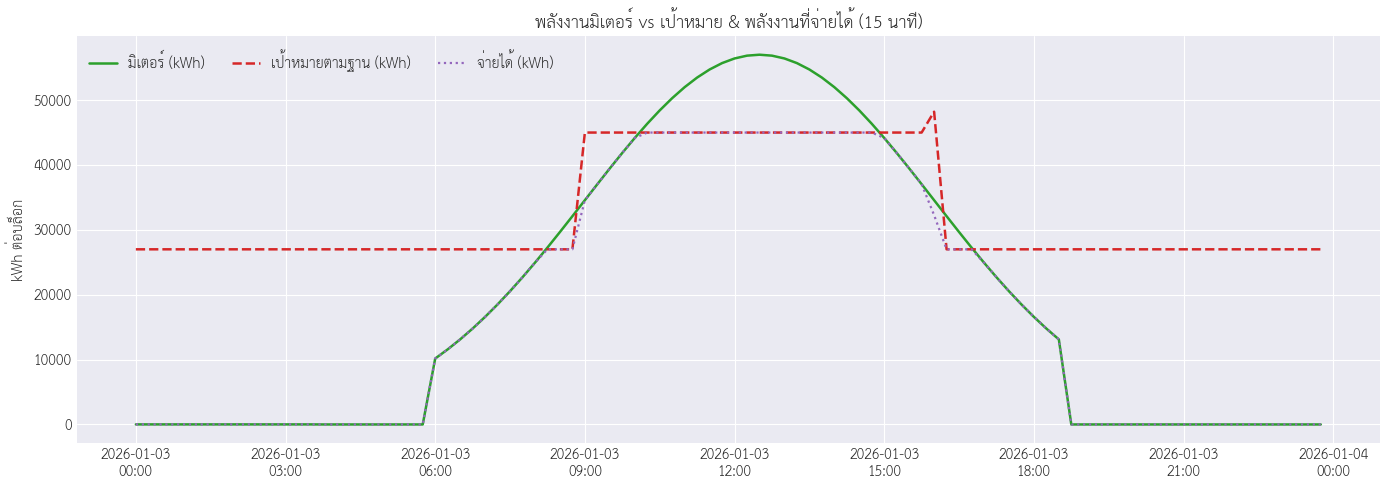

In [13]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(t, plot_df["meter_e_read_kwh"], label="มิเตอร์ (kWh)", color=colors["meter"], lw=1.8)
ax.plot(t, plot_df["target_meter_kwh"], label="เป้าหมายตามฐาน (kWh)", color=colors["target"], lw=1.8, linestyle="--")
ax.plot(t, plot_df["payable_kwh"], label="จ่ายได้ (kWh)", color=colors["payable"], lw=1.6, linestyle=":")

ax.set_title("พลังงานมิเตอร์ vs เป้าหมาย & พลังงานที่จ่ายได้ (15 นาที)")
ax.set_ylabel("kWh ต่อบล็อก")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
ax.legend(ncols=3, loc="upper left")
plt.tight_layout()
plt.show()

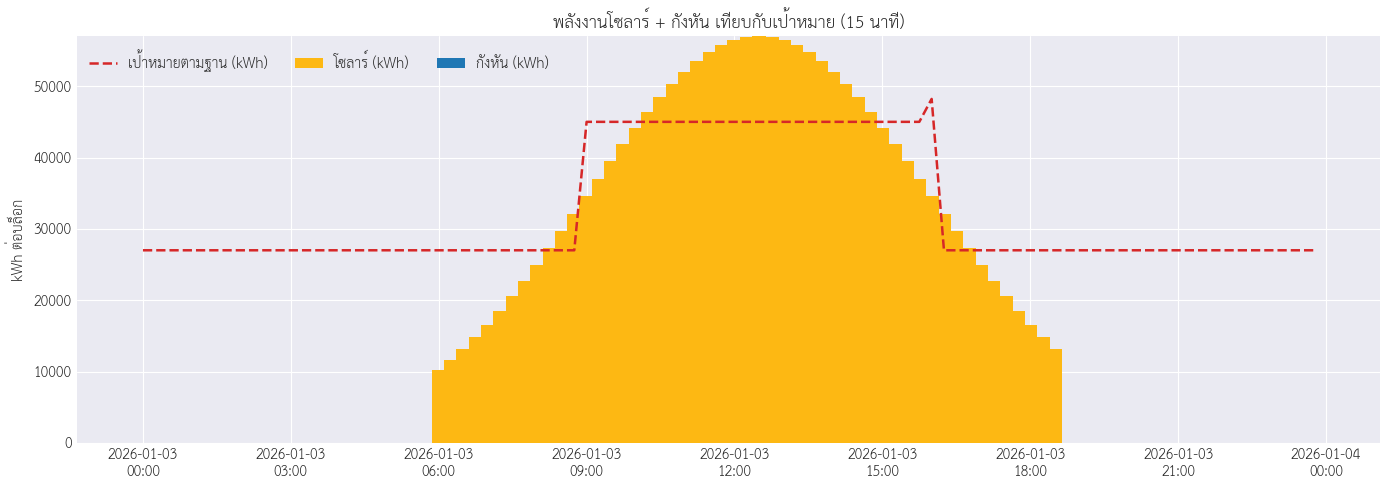

In [28]:
fig, ax = plt.subplots(figsize=(14, 5))

solar = plot_df["solar_kwh"].clip(lower=0)
turb = plot_df["turbines_kwh"].clip(lower=0)
ax.bar(t, solar, label="โซลาร์ (kWh)", color=colors["solar"], width=0.012, align="center")
ax.bar(t, turb, bottom=solar, label="กังหัน (kWh)", color=colors["turbines"], width=0.012, align="center")

ax.plot(t, plot_df["target_meter_kwh"], color=colors["target"], lw=1.8, linestyle="--", label="เป้าหมายตามฐาน (kWh)")

ax.set_title("พลังงานโซลาร์ + กังหัน เทียบกับเป้าหมาย (15 นาที)")
ax.set_ylabel("kWh ต่อบล็อก")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
ax.legend(ncols=3, loc="upper left")
plt.tight_layout()
plt.show()

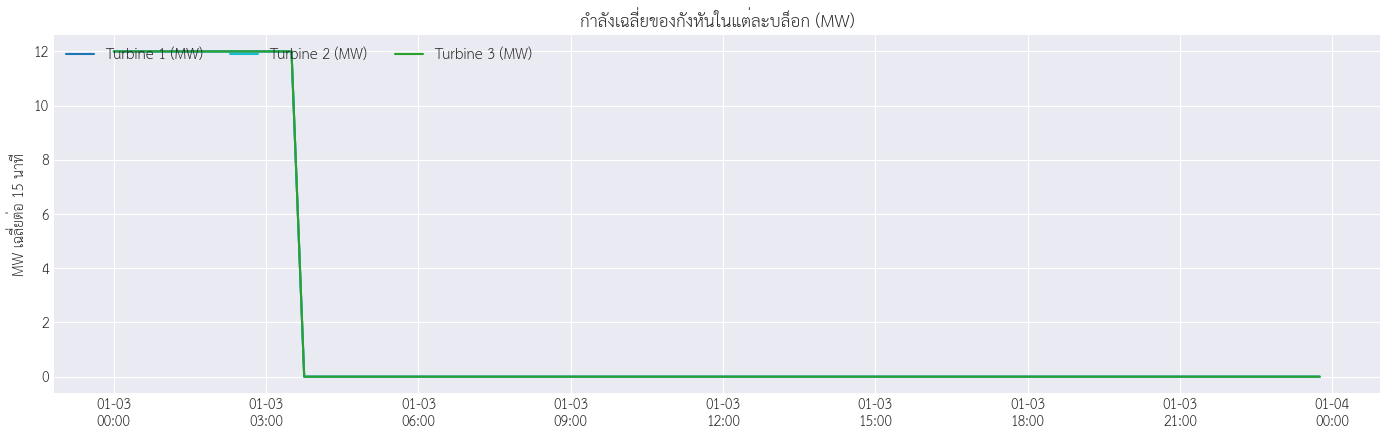

In [30]:
need_cols = {"turb1_mw", "turb2_mw", "turb3_mw"}
if need_cols.issubset(plot_df.columns):
    fig, ax = plt.subplots(figsize=(14, 4.5))
    ax.plot(t, plot_df["turb1_mw"], label="Turbine 1 (MW)", color=colors["t1"], lw=1.5)
    ax.plot(t, plot_df["turb2_mw"], label="Turbine 2 (MW)", color=colors["t2"], lw=1.5)
    ax.plot(t, plot_df["turb3_mw"], label="Turbine 3 (MW)", color=colors["t3"], lw=1.5)
    ax.set_title("กำลังเฉลี่ยของกังหันในแต่ละบล็อก (MW)")
    ax.set_ylabel("MW เฉลี่ยต่อ 15 นาที")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d\n%H:%M"))
    ax.legend(ncols=3, loc="upper left")
    plt.tight_layout()
    plt.show()
else:
    print("Skip Plot C: average MW columns not found (turb1_mw/turb2_mw/turb3_mw).")

In [32]:
soe_cols = {"turb1_soe_mwh", "turb2_soe_mwh", "turb3_soe_mwh"}
if soe_cols.issubset(plot_df.columns):
    fig, ax = plt.subplots(figsize=(14, 4.5))
    ax.plot(t, plot_df["turb1_soe_mwh"], label="SoE Turbine 1 (MWh)", color=colors["t1"], lw=1.5)
    ax.plot(t, plot_df["turb2_soe_mwh"], label="SoE Turbine 2 (MWh)", color=colors["t2"], lw=1.5)
    ax.plot(t, plot_df["turb3_soe_mwh"], label="SoE Turbine 3 (MWh)", color=colors["t3"], lw=1.5)
    ax.set_title("State of Energy (MWh) ต่อบล็อก")
    ax.set_ylabel("MWh")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d\n%H:%M"))
    ax.legend(ncols=3, loc="upper left")
    plt.tight_layout()
    plt.show()
else:
    print("Skip Plot D: SoE columns not found. Add them as shown above to enable this plot.")

Skip Plot D: SoE columns not found. Add them as shown above to enable this plot.


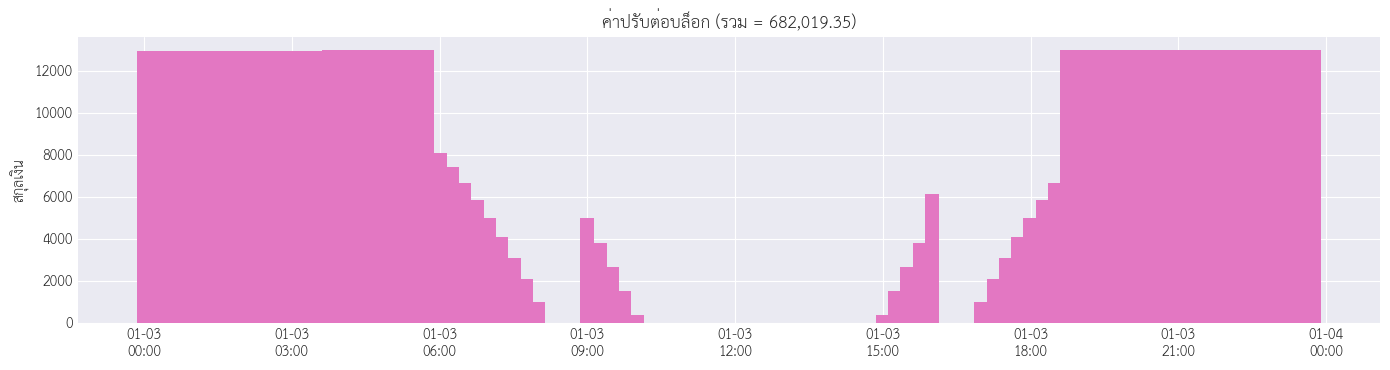

In [34]:
fig, ax = plt.subplots(figsize=(14, 3.8))
pen = plot_df["penalty_currency"].fillna(0.0)
ax.bar(t, pen, color=colors["penalty"], width=0.012)
ax.set_title(f"ค่าปรับต่อบล็อก (รวม = {pen.sum():,.2f})")
ax.set_ylabel("สกุลเงิน")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d\n%H:%M"))
plt.tight_layout()
plt.show()

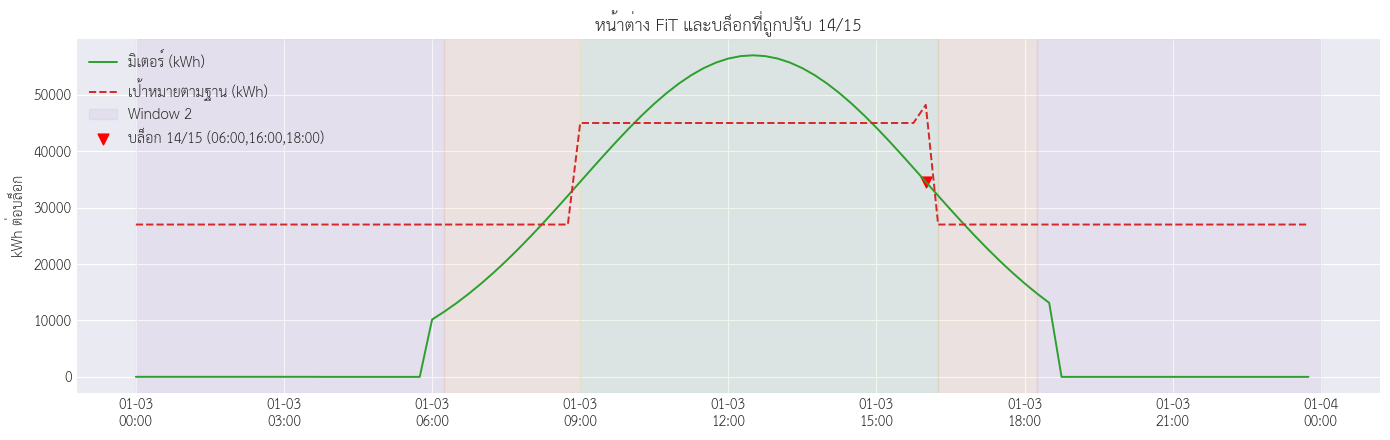

In [36]:
# Assign a color per FiT window
win_color = {1: "tab:green", 2: "tab:purple", 3: "tab:orange"}

fig, ax = plt.subplots(figsize=(14, 4.5))

# Base signal to see in the background
ax.plot(t, plot_df["meter_e_read_kwh"], label="มิเตอร์ (kWh)", color=colors["meter"], lw=1.4)
ax.plot(t, plot_df["target_meter_kwh"], label="เป้าหมายตามฐาน (kWh)", color=colors["target"], lw=1.4, linestyle="--")

# Shade windows
current_win = None
start_idx = 0
for i in range(len(plot_df)):
    w = int(plot_df.loc[i, "window_id"])
    if current_win is None:
        current_win = w
        start_idx = i
    elif w != current_win or i == len(plot_df) - 1:
        end_idx = i if w != current_win else i + 1
        ax.axvspan(t.iloc[start_idx], t.iloc[end_idx - 1] + pd.Timedelta(minutes=15),
                   alpha=0.08, color=win_color.get(current_win, "gray"),
                   label=f"Window {current_win}" if start_idx == 0 else None)
        current_win = w
        start_idx = i

# Mark adjusted 14/15 boundary blocks
adj_mask = plot_df["adjusted_flag"].astype(bool)
ax.scatter(t[adj_mask], plot_df.loc[adj_mask, "meter_e_read_kwh"],
           marker="v", s=60, color="red", label="บล็อก 14/15 (06:00,16:00,18:00)")

ax.set_title("หน้าต่าง FiT และบล็อกที่ถูกปรับ 14/15")
ax.set_ylabel("kWh ต่อบล็อก")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d\n%H:%M"))
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

,date,revenue,penalties,total_payable_kwh,total_e_use_kwh,total_meter_kwh,hit_rate_%
0,2026-01-03,6.090486e+06,682019.3456,1.693126e+06,1.859722e+06,1862026.86,54.371431


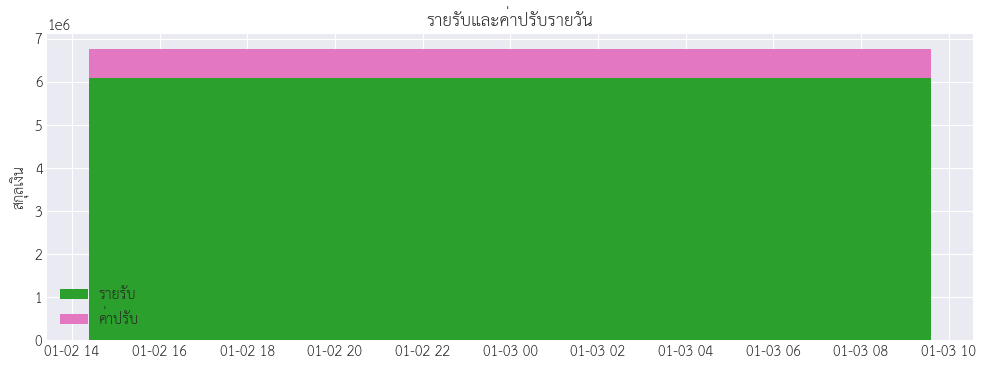

In [44]:
plot_df["date"] = plot_df["ts_start"].dt.date
daily = plot_df.groupby("date").agg(
    revenue=("payment_currency", "sum"),
    penalties=("penalty_currency", "sum"),
    total_payable_kwh=("payable_kwh", "sum"),
    total_e_use_kwh=("e_use_kwh", "sum"),
    total_meter_kwh=("meter_e_read_kwh", "sum"),
).reset_index()
daily["hit_rate_%"] = 100 * (1 - (plot_df["shortfall_kwh"].sum() / plot_df["base_kwh_y"].sum())) if "shortfall_kwh" in plot_df else np.nan

display(daily)

fig, ax = plt.subplots(figsize=(10, 3.8))
ax.bar(daily["date"], daily["revenue"], color="#2ca02c", label="รายรับ")
ax.bar(daily["date"], daily["penalties"], bottom=daily["revenue"], color=colors["penalty"], label="ค่าปรับ")
ax.set_title("รายรับและค่าปรับรายวัน")
ax.set_ylabel("สกุลเงิน")
ax.legend()
plt.tight_layout()
plt.show()